<a href="https://colab.research.google.com/github/NicoWeiner/MasterProject/blob/master/Funda_Analysis_v5_only_relevant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funda Analysis v5 - only relevant


## Preparation:

In [1]:
from pandas import DataFrame, read_csv, read_excel
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import keras
import tensorflow
import statsmodels.api as sm
import sklearn
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import os
%matplotlib inline

#For Scikit Regression & Tensorflow Neural Network: 

from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib notebook

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

## Checkpoint. Loading xlsx 

In [0]:
df = pd.read_excel("/content/drive/My Drive/Datasets/Funda_informal_features.xlsx", sep='\t', error_bad_lines=False, dtype='unicode', lineterminator='\n')
pd.options.display.max_columns = None

## Descriptives exploration

### preparing dataframe

In [0]:
dftest = df
dftest['livingarea'] = dftest['livingarea'].astype(int)
dftest['livingarea_range'] = pd.qcut(dftest['livingarea'], 5, labels=["very small", "small", "medium", "big", "very big"])
dftest = pd.concat([dftest['livingarea_range'],dftest.drop('livingarea_range',axis=1)], axis=1)

In [5]:
dftest2 = dftest
mean_col = dftest2.groupby(['city'])['sellingprice'].count() # not resetting the index!
dftest2 = dftest2.set_index(['city']) # make the same index here
dftest2['listings_per_city'] = mean_col
dftest2 = dftest2.reset_index() # to take the hierarchical index off again
dftest2 = dftest2.rename(columns={'perc_price_of_avg': 'price_m2_ratio'})
dftest2.listings_per_city = pd.to_numeric(dftest2.listings_per_city, errors='coerce').fillna(0).astype(np.int64)
dftest2['Population density'] = pd.to_numeric(dftest2['Population density'], errors='coerce').fillna(0).astype(np.int64)
dftest2 = pd.concat([dftest2['listings_per_city'],dftest2.drop('listings_per_city',axis=1)], axis=1)
dftest2['marketheat_ratio'] = dftest2['listings_per_city'] / dftest2['Population density'] *100
dftest2['marketheat_ratio'] = pd.to_numeric(dftest2['marketheat_ratio'], errors='coerce').fillna(0).astype(np.int64)
dftest2 = pd.concat([dftest2['marketheat_ratio'],dftest2.drop('marketheat_ratio',axis=1)], axis=1)
dftest2

,marketheat_ratio,listings_per_city,city,livingarea_range,globalid,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_class,price_m2_ratio,avg_price_m2_per_city,price_m2,constructionyear_range,timetosell_range,pricerange,publicationdate,postcodelong,sellingprice,description,categoryhouse,constructionyear,gardenindication,totalarea,livingarea,dateofselling,province,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
0,182,9394,Amsterdam,very small,4132354,True,True,False,True,3,expensive,138,5605,7735,old,very slow,1.0,2018-03-07,1011VK,410000,OPEN AVOND 12 APRIL TUSSEN 17:00 - 19:00uur VR...,Appartement,1964,0,NaN,53,2018-08-08,Noord Holland,423114,430933,126007,109354,304288,208818,105580,258090,96088,113428,5160,30,70,5,28700,154,central_location,782,13.48,28.13,71.87,49.49,7.80,3.20,0.00,0.38,1.79,0.51,0.38,3.32,12.28,17.39,5.50,4.73,5.75,0.38,10.49,5.12,1.92,0.90,2.56,1.66,1.92,1.02,1.02,0.51,0.13,0.26,7.03,0.00,0.51,0.26,1.66,6.78,2.05,0.77,0.90,1.79,1.41,1.28,0.64,0.26,0.13,0.13,1.53,0.13,0.13,0.13,1.02,3.96,1.15,0.77,1.53,0.26,0.38,2.17,8.44,0.51,18.41,1.02,13.68,3.84,2.94,2.05,1.92,1.28,0.00,0.00,1.53,0.00,0.38,0.00,0.00,0,0,1,0,0,0,0,0,0
1,13,703,Amsterdam Zuidoost,very small,4087960,False,True,False,False,2,normal,85,2844,2430,medium,fast,0.2,2018-02-01,1108HC,175000,Indien u de woning zou willen bekijken mailt u...,Appartement,1978,0,NaN,72,2018-02-19,Noord Holland,423114,430933,126007,109354,304288,208818,105580,258090,96088,113428,5160,30,70,5,28700,18,appartementencomplex,448,17.23,30.13,67.86,45.98,3.57,2.01,0.00,0.67,1.34,0.00,0.00,0.89,13.84,16.29,5.36,2.01,4.91,0.00,9.82,4.69,2.23,0.22,5.58,1.79,1.34,0.00,1.34,1.12,0.00,0.22,4.91,0.00,0.45,0.00,0.67,4.91,1.79,0.22,0.89,0.89,0.89,0.67,1.12,0.89,0.00,0.00,0.45,0.00,0.00,0.00,0.22,2.23,1.34,0.22,0.22,0.22,0.22,2.90,7.81,1.56,18.53,0.89,13.84,4.46,0.89,0.67,4.24,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0,1,0,0,0,0,0,0,0
2,115,1742,Dordrecht,big,4096821,True,True,False,True,2,normal,96,2225,2150,new,slow,0.6,2018-02-09,3315MT,279500,"Op aantrekkelijke locatie, met uitzicht op een...",Woonhuis,1994,1,201,130,2018-04-30,Zuid Holland,58577,59849,18872,14053,29711,33761,22029,21557,14869,18338,1508,56,43,3,24600,80,great_view,579,13.47,29.53,67.70,44.21,3.97,2.59,0.00,0.35,0.52,0.17,0.17,2.76,11.74,16.06,4.32,3.80,6.56,0.35,7.94,4.84,2.25,1.21,6.91,0.86,3.45,1.73,1.73,1.38,0.00,0.17,2.25,0.00,0.00,0.00,0.52,6.74,1.38,0.52,1.38,1.90,0.86,1.90,1.38,0.86,0.00,0.52,1.04,0.00,0.17,0.00,0.86,2.42,0.69,0.17,0.35,0.86,0.35,1.73,6.39,0.86,14.68,0.69,10.02,3.97,0.86,3.63,5.53,0.17,0.00,0.00,0.52,0.00,0.17,0.00,0.00,0,0,0,1,0,0,0,0,0
3,129,2768,Groningen,small,4134064,True,False,False,False,1,cheap,56,2503,1423,medium,very fast,0.2,2018-03-08,9732AM,139500,MEERPAAL 208 TE GRONINGEN\n\nEen schitterend e...,Appartement,1972,0,NaN,98,2018-03-19,Groningen,101299,101511,24313,47673,61815,43312,25697,75483,25488,21570,2137,38,61,4,22400,11,14,528,16.50,27.27,69.51,50.38,6.25,2.46,0.00,0.76,0.95,0.00,0.00,3.60,13.07,16.48,6.06,4.17,6.44,1.52,9.47,6.63,3.79,0.76,3.60,1.70,2.65,1.70,0.95,0.57,0.00,0.00,5.49,0.00,0.00,0.00,1.70,9.47,1.70,0.76,1.14,2.46,1

In [6]:
df1 = dftest2
df1[['light_flooded', 'garage_and_parking', 'noisy_property', 'quiet_property']] = df1[['light_flooded', 'garage_and_parking', 'noisy_property', 'quiet_property']].replace(to_replace=['True', 'False'], value=[1, 0])
df1 = df1.apply(pd.to_numeric, errors='coerce').fillna(df1)
df1 = df1.set_index('globalid')
df1

,marketheat_ratio,listings_per_city,city,livingarea_range,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_class,price_m2_ratio,avg_price_m2_per_city,price_m2,constructionyear_range,timetosell_range,pricerange,publicationdate,postcodelong,sellingprice,description,categoryhouse,constructionyear,gardenindication,totalarea,livingarea,dateofselling,province,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
globalid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4132354,182,9394,Amsterdam,very small,1,1,0,1,3,expensive,138,5605,7735,old,very slow,1,2018-03-07,1011VK,410000,OPEN AVOND 12 APRIL TUSSEN 17:00 - 19:00uur VR...,Appartement,1964,0,NaN,53,2018-08-08,Noord Holland,423114,430933,126007,109354,304288,208818,105580,258090,96088,113428,5160,30,70,5,28700,154,central_location,782,13.48,28.13,71.87,49.49,7.8,3.2,0,0.38,1.79,0.51,0.38,3.32,12.28,17.39,5.5,4.73,5.75,0.38,10.49,5.12,1.92,0.9,2.56,1.66,1.92,1.02,1.02,0.51,0.13,0.26,7.03,0,0.51,0.26,1.66,6.78,2.05,0.77,0.9,1.79,1.41,1.28,0.64,0.26,0.13,0.13,1.53,0.13,0.13,0.13,1.02,3.96,1.15,0.77,1.53,0.26,0.38,2.17,8.44,0.51,18.41,1.02,13.68,3.84,2.94,2.05,1.92,1.28,0,0,1.53,0,0.38,0,0,0,0,1,0,0,0,0,0,0
4087960,13,703,Amsterdam Zuidoost,very small,0,1,0,0,2,normal,85,2844,2430,medium,fast,0.2,2018-02-01,1108HC,175000,Indien u de woning zou willen bekijken mailt u...,Appartement,1978,0,NaN,72,2018-02-19,Noord Holland,423114,430933,126007,109354,304288,208818,105580,258090,96088,113428,5160,30,70,5,28700,18,appartementencomplex,448,17.23,30.13,67.86,45.98,3.57,2.01,0,0.67,1.34,0,0,0.89,13.84,16.29,5.36,2.01,4.91,0,9.82,4.69,2.23,0.22,5.58,1.79,1.34,0,1.34,1.12,0,0.22,4.91,0,0.45,0,0.67,4.91,1.79,0.22,0.89,0.89,0.89,0.67,1.12,0.89,0,0,0.45,0,0,0,0.22,2.23,1.34,0.22,0.22,0.22,0.22,2.9,7.81,1.56,18.53,0.89,13.84,4.46,0.89,0.67,4.24,0,0,0,0.67,0,0,0,0,0,1,0,0,0,0,0,0,0
4096821,115,1742,Dordrecht,big,1,1,0,1,2,normal,96,2225,2150,new,slow,0.6,2018-02-09,3315MT,279500,"Op aantrekkelijke locatie, met uitzicht op een...",Woonhuis,1994,1,201,130,2018-04-30,Zuid Holland,58577,59849,18872,14053,29711,33761,22029,21557,14869,18338,1508,56,43,3,24600,80,great_view,579,13.47,29.53,67.7,44.21,3.97,2.59,0,0.35,0.52,0.17,0.17,2.76,11.74,16.06,4.32,3.8,6.56,0.35,7.94,4.84,2.25,1.21,6.91,0.86,3.45,1.73,1.73,1.38,0,0.17,2.25,0,0,0,0.52,6.74,1.38,0.52,1.38,1.9,0.86,1.9,1.38,0.86,0,0.52,1.04,0,0.17,0,0.86,2.42,0.69,0.17,0.35,0.86,0.35,1.73,6.39,0.86,14.68,0.69,10.02,3.97,0.86,3.63,5.53,0.17,0,0,0.52,0,0.17,0,0,0,0,0,1,0,0,0,0,0
4134064,129,2768,Groningen,small,1,0,0,0,1,cheap,56,2503,1423,medium,very fast,0.2,2018-03-08,9732AM,139500,MEERPAAL 208 TE GRONINGEN\n\nEen schitterend e...,Appartement,1972,0,NaN,98,2018-03-19,Groningen,101299,101511,24313,47673,61815,43312,25697,75483,25488,21570,2137,38,61,4,22400,11,14,528,16.5,27.27,69.51,50.38,6.25,2.46,0,0.76,0.95,0,0,3.6,13.07,16.48,6.06,4.17,6.44,1.52,9.47,6.63,3.79,0.76,3.6,1.7,2.65,1.7,0.95,0.57,0,0,5.49,0,0,0,1.7,9.47,1.7,0.76,1.14,2.46,1.33,3.41,1.14,0.76,0.19,0.19,1.52,0,0.19,0,0.95,3.22,0.76,0.95,0.76,0.38,0.57,1.7,7.77,0.95,12.5,0

In [0]:
df2 = df1
df2[['light_flooded', 'garage_and_parking', 'noisy_property', 'quiet_property']] = df2[['light_flooded', 'garage_and_parking', 'noisy_property', 'quiet_property']].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)

In [8]:
df3 = df2
df3 = df3.apply(pd.to_numeric, errors='coerce')
df3 = df3.drop(['postcodelong'], 1)
df3 = df3.dropna(axis=1, how='all')
# df3 = df3.dropna()
df3

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,pricerange,sellingprice,constructionyear,gardenindication,totalarea,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
globalid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4132354,182,9394,1,1,0,1,3,138,5605,7735,1.0,410000,1964,0,NaN,53,423114,430933,126007,109354,304288,208818,105580,258090,96088,113428,5160,30,70,5,28700.0,154,NaN,782,13.48,28.13,71.87,49.49,7.80,3.20,0.0,0.38,1.79,0.51,0.38,3.32,12.28,17.39,5.50,4.73,5.75,0.38,10.49,5.12,1.92,0.90,2.56,1.66,1.92,1.02,1.02,0.51,0.13,0.26,7.03,0.00,0.51,0.26,1.66,6.78,2.05,0.77,0.90,1.79,1.41,1.28,0.64,0.26,0.13,0.13,1.53,0.13,0.13,0.13,1.02,3.96,1.15,0.77,1.53,0.26,0.38,2.17,8.44,0.51,18.41,1.02,13.68,3.84,2.94,2.05,1.92,1.28,0.0,0.0,1.53,0.0,0.38,0.0,0.0,0,0,1,0,0,0,0,0,0
4087960,13,703,0,1,0,0,2,85,2844,2430,0.2,175000,1978,0,NaN,72,423114,430933,126007,109354,304288,208818,105580,258090,96088,113428,5160,30,70,5,28700.0,18,NaN,448,17.23,30.13,67.86,45.98,3.57,2.01,0.0,0.67,1.34,0.00,0.00,0.89,13.84,16.29,5.36,2.01,4.91,0.00,9.82,4.69,2.23,0.22,5.58,1.79,1.34,0.00,1.34,1.12,0.00,0.22,4.91,0.00,0.45,0.00,0.67,4.91,1.79,0.22,0.89,0.89,0.89,0.67,1.12,0.89,0.00,0.00,0.45,0.00,0.00,0.00,0.22,2.23,1.34,0.22,0.22,0.22,0.22,2.90,7.81,1.56,18.53,0.89,13.84,4.46,0.89,0.67,4.24,0.00,0.0,0.0,0.67,0.0,0.00,0.0,0.0,0,1,0,0,0,0,0,0,0
4096821,115,1742,1,1,0,1,2,96,2225,2150,0.6,279500,1994,1,201.0,130,58577,59849,18872,14053,29711,33761,22029,21557,14869,18338,1508,56,43,3,24600.0,80,NaN,579,13.47,29.53,67.70,44.21,3.97,2.59,0.0,0.35,0.52,0.17,0.17,2.76,11.74,16.06,4.32,3.80,6.56,0.35,7.94,4.84,2.25,1.21,6.91,0.86,3.45,1.73,1.73,1.38,0.00,0.17,2.25,0.00,0.00,0.00,0.52,6.74,1.38,0.52,1.38,1.90,0.86,1.90,1.38,0.86,0.00,0.52,1.04,0.00,0.17,0.00,0.86,2.42,0.69,0.17,0.35,0.86,0.35,1.73,6.39,0.86,14.68,0.69,10.02,3.97,0.86,3.63,5.53,0.17,0.0,0.0,0.52,0.0,0.17,0.0,0.0,0,0,0,1,0,0,0,0,0
4134064,129,2768,1,0,0,0,1,56,2503,1423,0.2,139500,1972,0,NaN,98,101299,101511,24313,47673,61815,43312,25697,75483,25488,21570,2137,38,61,4,22400.0,11,14.0,528,16.50,27.27,69.51,50.38,6.25,2.46,0.0,0.76,0.95,0.00,0.00,3.60,13.07,16.48,6.06,4.17,6.44,1.52,9.47,6.63,3.79,0.76,3.60,1.70,2.65,1.70,0.95,0.57,0.00,0.00,5.49,0.00,0.00,0.00,1.70,9.47,1.70,0.76,1.14,2.46,1.33,3.41,1.14,0.76,0.19,0.19,1.52,0.00,0.19,0.00,0.95,3.22,0.76,0.95,0.76,0.38,0.57,1.70,7.77,0.95,12.50,0.38,8.52,3.79,1.89,0.76,3.98,1.14,0.0,0.0,1.14,0.0,0.19,0.0,0.0,0,0,0,0,0,0,0,0,0
4089019,10,204,1,1,0,0,3,141,1559,2212,0.4,239000,2010,1,230.0,108,43100,43662,11132,9093,20368,26737,19432,20591,12405,12034,1931,46,52,5,22500.0,56,14.0,421,70.17,35.15,51.78,31.12,1.66,0.24,0.0,0.00,0.00,0.24,0.24,0.71,5.23,13.78,3.09,3.80,5.23,1.19,8.79,2.38,1.66,0.24,13.30,1.43,0.71,0.48,0.24,0.24,0.00,0.00,5.23,0.00,0.00,0.00,1.19,5.23,0.71,0.71,0.71,0.95,1.19,1.90,0.48,0.48,0.00,0.00,0.48,0.00,0.00,0.00,0.24,2.38,0.00,0.71,1.43,0.24,0.00,0.71,7.84,0.24,11.16,0.48,9.03,1.66,0.95,0.71,3.56,1.43,0.0,0.0,0.24,0.0,0.00,0.0,

### Running descriptive analyses

In this section, we check the means of variables under different conditions. 

- For instance, if a listing is categorized with the topic "antique_charme", is the mean timetosell lower or higher than a listing not categorized with this topic?

- What about the mean sellingprice?

Or more complex tests: 
- percentagewise, how much cheaper or more expensive is an antique_charme listing in terms of price per m2 compared to the average price per m2?

#### Antique_charme

In [9]:
antiquedf = df3.groupby('antique_charme').mean()
antiquedf

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,pricerange,sellingprice,constructionyear,gardenindication,totalarea,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
antique_charme,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,86.669019,1567.604191,0.606717,0.515383,0.055503,0.415662,1.907498,99.183878,2809.886346,2800.494507,0.590117,314164.889751,1954.813126,0.697017,539.323767,118.238281,76631.035368,78168.739659,24296.912955,20565.063246,46877.305497,39683.087352,23377.405976,37233.593200,18524.116409,22159.873334,1698.875981,56.444136,42.583857,3.273426,25643.721006,59.972802,10.264041,376.360231,15.529002,32.271638,62.919082,41.704773,4.199852,1.817815,0.007306,0.212531,1.093555,0.247629,0.234225,1.809116,11.308194,15.097044,3.889180,3.285374,5.735591,0.214340,7.899698,5.29028,1.711964,0.485295,4.612556,1.459971,3.000676,1.710551,1.298888,1.081923,0.024469,0.152220,4.126416,0.035104,0.138356,0.088394,0.513531,4.821948,1.088014,0.463244,0.737062,0.952773,0.946189,1.067064,1.118174,0.571593,0.085985,0.304910,1.176266,0.080496,0.089796,0.010358,0.876603,3.072446,0.694844,0.981876,0.918780,0.844052,0.081121,1.334205,6.940963,0.518235,13.991982,0.536252,10.747431,2.976253,1.475745,1.697467,4.668933,0.482563,0.011539,0.001846,0.956684,0.001825,0.275667,0.011604,0.002411,0.077456,0.025087,0.08728,0.030597,0.161192,0.034748,0.033106,0.076782
1,85.691114,1775.947410,0.607001,0.304134,0.080627,0.368604,2.155077,108.419294,3055.418818,3317.485823,0.768763,447720.622208,1876.284334,0.891177,363.064129,135.090923,76932.293363,79106.220339,24953.890227,21629.952637,46578.544274,39073.747822,23802.378742,37365.821004,18719.599081,22179.041343,2242.508950,53.039918,45.890860,3.494218,26736.359316,52.534770,NaN,382.478853,16.974524,32.701248,61.478809,40.343951,3.254472,1.244149,0.004519,0.127792,0.651031,0.232387,0.216830,1.522572,10.838462,15.370990,3.393799,3.047371,6.057374,0.130059,7.071462,4.84211,1.543369,0.336323,4.455818,1.458585,2.607104,1.510844,1.116523,0.973477,0.029127,0.089062,3.499895,0.040097,0.133643,0.154760,0.486525,4.061437,0.749895,0.617690,0.593743,0.758912,0.728088,0.827855,1.019853,0.471519,0.067217,0.358801,1.141831,0.085786,0.076192,0.007610,0.826784,2.820078,0.563507,1.029178,1.010589,0.790520,0.042853,1.066384,6.239870,0.339770,15.028280,0.698951,11.671828,2.842763,1.536651,1.640916,5.261437,0.329864,0.009796,0.001722,0.764880,0.001392,0.198598,0.013914,0.002303,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


Observations: 
- The average sellingprice is higher when a listing can be classified with the topic antique_charm
- The timetosell is lower when classified with antique_charm

In [10]:
antiquedf2 = antiquedf[['timetosell', 'sellingprice', 'pricerange', 'price_m2', 'avg_price_m2_per_city', 'price_m2_ratio', 'price_m2', 'constructionyear', 'totalarea', 'livingarea', 'quiet_property', 'gardenindication', 'light_flooded', 'garage_and_parking', 'female', 'male', 'posemo', 'negemo', 'pronoun', 'you', 'we']]
antiquedf2

,timetosell,sellingprice,pricerange,price_m2,avg_price_m2_per_city,price_m2_ratio,price_m2,constructionyear,totalarea,livingarea,quiet_property,gardenindication,light_flooded,garage_and_parking,female,male,posemo,negemo,pronoun,you,we
antique_charme,,,,,,,,,,,,,,,,,,,,,
0,59.972802,314164.889751,0.590117,2800.494507,2809.886346,99.183878,2800.494507,1954.813126,539.323767,118.238281,0.415662,0.697017,0.606717,0.515383,0.088394,0.513531,1.710551,1.298888,4.199852,1.093555,0.212531
1,52.534770,447720.622208,0.768763,3317.485823,3055.418818,108.419294,3317.485823,1876.284334,363.064129,135.090923,0.368604,0.891177,0.607001,0.304134,0.154760,0.486525,1.510844,1.116523,3.254472,0.651031,0.127792


Above, we have selected all mean differences that are mentionable. 

- The sellingprice shows one of the largest differences so that antique_charme listings are much more expensive in general 
  - (447.720€ compared to 314.164€)

- but also in m2 price compared to average m2 price on city level 
  - (99.14% of mean city m2 prices if no antique_charme and 108.42% of mean city m2 prices if yes antique_charme)

#### Pricerange

In [11]:
pricerangeDF = df3.groupby('pricerange').mean()
pricerangeDF

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,sellingprice,constructionyear,gardenindication,totalarea,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
pricerange,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.2,93.577057,1272.566967,0.554002,0.345744,0.037148,0.340079,1.581285,84.067926,2421.024549,2029.399042,152111.880834,1953.064459,0.537880,251.629812,85.374493,62667.012909,63869.887232,19886.748985,17306.534611,35480.814769,33035.079876,20827.721900,28443.907864,15598.760259,18404.208033,1514.957525,55.626635,43.317024,3.236048,24284.929808,48.400705,12.024896,291.766573,14.615986,33.356570,62.917972,40.819455,3.895861,1.668692,0.011130,0.233864,0.976554,0.215010,0.199452,1.727501,10.798636,15.266086,3.834014,3.142839,5.551118,0.248990,7.830986,5.238691,1.594249,0.415435,4.922463,1.391018,2.920134,1.686714,1.239164,1.007957,0.013178,0.170850,4.065961,0.029581,0.136008,0.078182,0.452721,4.757068,1.210500,0.417805,0.693431,0.874783,0.964187,0.985620,1.069190,0.546291,0.082276,0.304010,1.236386,0.057036,0.077939,0.010885,0.942360,3.209717,0.735224,1.028554,0.880813,0.947747,0.082576,1.251845,6.850504,0.500877,13.983057,0.531792,10.696543,3.070557,1.674416,1.565389,5.166736,0.664541,0.007035,0.001145,0.954617,0.001311,0.308037,0.009961,0.001642,0.013444,0.141770,0.013613,0.157187,0.023591,0.057469,0.043828,0.032018,0.034808
0.4,89.190588,1244.085599,0.610037,0.436158,0.045361,0.408161,1.755503,91.623738,2627.927595,2428.849650,216735.878183,1963.958570,0.721370,217.912546,101.213194,61959.573403,63121.533552,19914.372420,16730.194043,35994.845540,32661.106091,19780.588861,27823.465763,15236.834192,18295.365927,1485.009769,57.784929,41.262666,3.139955,25064.466551,51.165748,10.737040,343.953001,15.244666,32.771664,63.177289,41.626823,4.095767,1.765142,0.007195,0.214253,1.059576,0.241690,0.229414,1.756334,11.366215,15.063830,3.919448,3.243817,5.723501,0.214969,8.008552,5.232081,1.661462,0.423661,4.671845,1.416232,3.011951,1.693172,1.325439,1.108351,0.018124,0.159196,4.168678,0.032029,0.143057,0.082247,0.507690,4.659934,1.071797,0.445662,0.702334,0.864854,0.942678,0.979931,1.063591,0.539765,0.082634,0.291659,1.203480,0.070085,0.085117,0.009912,0.900599,3.091918,0.707274,1.024371,0.882376,0.877059,0.073007,1.301498,7.064748,0.501470,14.091604,0.533750,10.866508,2.962685,1.523856,1.689844,4.885212,0.493637,0.008891,0.001789,0.943471,0.001431,0.285646,0.010170,0.002793,0.020253,0.085987,0.018764,0.082353,0.041042,0.115681,0.036515,0.034639,0.066627
0.6,83.436597,1494.649007,0.624214,0.520160,0.058935,0.431467,1.896387,97.242168,2795.308991,2671.502923,272563.035438,1960.681219,0.751241,296.536872,112.560480,73742.822559,75200.858715,23510.133949,19739.161224,44823.828516,38284.030226,22586.527358,35205.954302,17857.634253,21440.107446,1725.688114,57.011555,42.052289,3.229647,25661.466119,54.485190,9.667552,373.734611,15.547818,32.333822,63.228151,41.907050,4.219134,1.843955,0.005483,0.210939,1.130542,0.249263,0.235892,1.778135,11.4

#### Central_location

In [12]:
centrallocation = df3.groupby('central_location').mean()
centrallocation

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,pricerange,sellingprice,constructionyear,gardenindication,totalarea,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,antique_charme,appartementencomplex,great_view,house_materials,luxurious,measurements,plotarea,trivialising
central_location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,86.201874,1511.325141,0.607512,0.511347,0.054464,0.411791,1.918428,99.640767,2790.658205,2796.197194,0.595038,318566.765696,1952.463196,0.706160,535.728175,119.378019,73481.610363,74971.029341,23372.799325,19777.990723,44505.468168,38135.761563,22660.619926,35236.985811,17828.028521,21321.567552,1678.288732,56.595924,42.419898,3.263739,25637.043703,60.136856,10.264041,376.648904,15.573605,32.294245,62.817076,41.605348,4.157596,1.789047,0.007275,0.210182,1.072175,0.245042,0.231544,1.799270,11.267506,15.093074,3.869493,3.272707,5.743568,0.211001,7.875835,5.268146,1.704318,0.479236,4.615388,1.463587,2.989705,1.702951,1.295853,1.079667,0.024654,0.151714,4.089257,0.035084,0.134960,0.091000,0.510091,4.797683,1.078832,0.469123,0.731151,0.946528,0.941355,1.054713,1.115634,0.570032,0.084165,0.307708,1.171594,0.080981,0.089032,0.009994,0.871107,3.063572,0.685865,0.983513,0.923768,0.842847,0.080233,1.325950,6.920141,0.511366,13.982252,0.534910,10.757590,2.955631,1.477672,1.688643,4.717619,0.473964,0.011341,0.001864,0.947281,0.001636,0.274297,0.011607,0.002327,0.037495,0.07647,0.086169,0.030208,0.15914,0.034306,0.032685,0.075805
1,104.049880,4155.327338,0.575060,0.358513,0.135492,0.500719,1.841007,94.718225,3957.951319,3756.679616,0.661871,338626.926139,1930.807914,0.621823,296.957759,97.733813,204247.601679,208698.046283,62603.324700,53955.875300,142189.788969,101235.087530,52961.571463,118048.353477,46925.150360,56036.141247,3353.112950,45.161871,54.210312,3.998801,27567.170264,42.088489,NaN,373.967866,15.916492,32.009249,64.857237,43.658990,4.474758,2.110871,0.004319,0.179101,1.286818,0.329000,0.316108,1.772866,12.239875,15.672072,3.934106,3.436465,5.900633,0.221559,7.609321,5.505468,1.765439,0.504424,4.260914,1.311849,2.847799,1.715084,1.145317,1.008861,0.024036,0.077043,4.678218,0.043480,0.268365,0.083652,0.611559,4.650331,0.946830,0.459700,0.758765,0.911420,0.811144,1.203612,1.071866,0.483115,0.131046,0.273549,1.312751,0.068928,0.100034,0.020894,1.023108,3.048659,0.858523,0.987381,0.856384,0.811645,0.059036,1.262053,6.720257,0.525396,15.953676,0.836772,11.736695,3.606777,1.490151,1.968118,3.600185,0.598573,0.016890,0.000930,1.045962,0.008801,0.214278,0.015000,0.005612,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


Observations: 
- When a listing has the topic "central_location", it sells on average in 42 days while listings without central_location need on average 60 days!


#### price class

In [13]:
priceclass = df3.groupby('price_class_num').mean()
priceclass = priceclass.drop(priceclass.loc[[0]].index)
priceclass

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_m2_ratio,avg_price_m2_per_city,price_m2,pricerange,sellingprice,constructionyear,gardenindication,totalarea,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,Average_income,timetosell,Topic,WC,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,cogproc,insight,cause,discrep,tentat,certain,differ,percept,see,hear,feel,bio,body,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
price_class_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,99.432882,1804.329945,0.591928,0.400529,0.041929,0.400945,67.240748,3062.693566,1957.968970,0.428630,228259.101785,1957.487865,0.689892,341.113793,119.772844,83892.264701,85601.296711,26507.255664,22699.257672,51551.199383,43211.736597,25524.112096,41557.851755,20208.073302,24118.858000,1705.655262,54.922167,44.042664,3.382920,25464.903987,52.127771,10.820716,348.206510,15.181294,32.578571,63.121203,41.301428,4.124946,1.778909,0.008158,0.237615,1.055982,0.232591,0.215774,1.778051,11.027674,15.172159,3.872997,3.279088,5.655148,0.229006,7.886237,5.279908,1.697079,0.461299,4.849346,1.423007,3.037284,1.677087,1.365808,1.137645,0.018100,0.167142,4.153224,0.038079,0.143355,0.083093,0.488219,4.785113,1.103091,0.456528,0.732520,0.922869,0.917491,1.054184,1.056167,0.528877,0.084104,0.298247,1.164513,0.07028,0.080229,0.011004,0.873225,3.183384,0.747681,1.051731,0.884041,0.887742,0.080069,1.297831,6.947872,0.515128,14.251650,0.551748,10.937404,3.064318,1.549846,1.645689,4.807474,0.597592,0.008414,0.001521,0.925040,0.002631,0.280512,0.009751,0.002312,0.019275,0.068379,0.027675,0.122431,0.030075,0.084544,0.033381,0.034753,0.066396
2,81.417461,1451.748207,0.613577,0.512759,0.055484,0.416436,98.051298,2731.093723,2696.082433,0.607054,309937.446885,1957.426131,0.727560,397.238608,117.014673,72500.751281,73955.172424,23057.544039,19463.427688,44153.169989,37628.752769,22153.029221,34813.354525,17575.218232,21020.246138,1716.163164,56.958764,42.097986,3.242920,25762.107604,57.427436,9.981855,376.909409,15.640862,32.270824,62.898995,41.698366,4.146968,1.787251,0.006977,0.200380,1.079082,0.248729,0.236466,1.783519,11.375790,15.065681,3.873156,3.267052,5.765906,0.205267,7.882872,5.257322,1.692092,0.473549,4.598536,1.460337,3.007334,1.706110,1.308787,1.100601,0.022851,0.147314,4.105930,0.035673,0.138736,0.088851,0.515986,4.741734,1.059168,0.466328,0.722811,0.930957,0.928228,1.042780,1.110607,0.560716,0.084495,0.307609,1.187905,0.08020,0.089429,0.009758,0.886102,3.047310,0.683418,0.987034,0.919778,0.834546,0.076722,1.322568,6.927957,0.512080,14.052693,0.540739,10.818410,2.949265,1.466103,1.710272,4.691831,0.445057,0.011173,0.001740,0.958078,0.001503,0.272418,0.011538,0.002534,0.035794,0.070882,0.024581,0.076681,0.031454,0.157925,0.034469,0.031502,0.074845
3,87.101172,1688.304493,0.606055,0.644795,0.080554,0.423533,138.929755,2759.588150,3847.365116,0.799392,473911.130471,1925.228604,0.638393,1255.984187,124.160095,80972.762895,82700.443138,25676.266006,21662.555415,49793.695688,41790.554221,24750.134703,39676.700933,19530.872531,23401.974391,1748.195471,56.023656,42.973414,3.275881,25716.240955,78.345258,10.435305,415.706033,15.954048,31.940410,62.394853,41.997567,4.279562,1.851895,0.006641,0.197992,1.100161,0.261699,0.249422,1.878086,11.371952

#### constructionyear

In [14]:
constyear = df1.groupby('constructionyear_range').mean()
constyear

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,sellingprice,constructionyear,gardenindication,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,timetosell,WC,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
constructionyear_range,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
medium,80.371072,1019.453866,0.637078,0.551077,0.037660,0.469548,1.701807,89.119189,2610.971078,2310.667412,258694.453395,1978.854831,0.783630,115.694922,55261.747529,56253.021596,17608.454249,14563.712840,31598.486584,29560.392639,18183.722814,24438.374779,13760.577469,16336.680505,1462.202630,58.712193,40.324262,3.113834,52.766212,364.747264,0.000765,0.063670,0.019948,0.071937,0.038896,0.142874,0.037131,0.036807,0.081529
new,92.320883,1428.768094,0.698102,0.656319,0.053055,0.457250,2.011778,101.652449,2705.980090,2692.860296,334099.128992,1997.067076,0.725218,127.361656,69291.542553,70609.856762,22472.502061,18530.232579,41054.202546,36560.176075,21284.286055,31268.728106,16769.765206,20604.431340,1588.314686,57.750764,41.321135,3.263397,54.989316,403.729929,0.001402,0.110625,0.020779,0.093407,0.035557,0.192311,0.035585,0.029724,0.086509
old,76.529787,1334.673110,0.630541,0.459840,0.039225,0.419935,1.727979,91.387484,2763.861410,2517.368354,254879.121812,1961.947228,0.682717,104.831935,65960.837065,67370.763264,20827.911971,17853.406898,39227.379322,34292.116200,21130.785937,31512.868722,16214.548010,19063.744757,1582.981890,56.821477,42.106110,3.256150,53.051440,357.176397,0.010685,0.087830,0.019612,0.121528,0.037552,0.114188,0.036787,0.037524,0.062975
very new,90.875228,1519.313802,0.473809,0.563558,0.065081,0.323913,2.119473,108.043611,2845.993513,3040.269613,369726.052534,2015.374193,0.599129,126.308625,74722.340084,76198.529449,23903.402546,20232.329120,45642.861158,38519.341211,22622.935498,35834.381685,18047.343464,21650.093099,1678.623949,56.835333,42.216866,3.250061,78.932269,346.459587,0.001279,0.081709,0.020130,0.037307,0.011908,0.261177,0.017115,0.018303,0.064807
very old,93.168316,2565.684077,0.584704,0.308445,0.087494,0.394098,2.028561,107.712408,3168.103917,3544.480960,379886.942188,1809.276921,0.725639,120.410320,117734.810257,120335.004199,36718.009578,31778.373792,76661.080850,59241.224747,33671.125489,63010.924183,27809.818483,33074.830965,2279.091636,51.516251,47.519817,3.519414,59.896802,408.458640,0.167338,0.028302,0.040209,0.092585,0.022434,0.071186,0.039835,0.036442,0.073545


#### plot area

In [15]:
livingareaDF = df1.groupby('livingarea_range').mean()
livingareaDF

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,sellingprice,constructionyear,gardenindication,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,timetosell,WC,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
livingarea_range,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
big,82.760877,1136.247417,0.589202,0.580081,0.046343,0.429571,1.867170,95.705620,2693.107326,2530.278440,336283.684899,1965.748391,0.860795,132.702609,56573.746768,57619.862300,18248.819647,15100.846567,32603.495277,29953.265453,18287.182124,24974.920568,13994.482880,16724.650097,1430.001299,58.748539,40.263563,3.134246,63.041945,380.294144,0.035746,0.018862,0.017799,0.046845,0.034418,0.199540,0.029518,0.028957,0.092479
medium,83.199431,1210.839068,0.597046,0.495670,0.043688,0.429321,1.816141,93.001127,2679.653013,2448.357338,279459.537371,1964.048642,0.834114,114.184126,60377.705926,61511.681190,19354.185758,16136.769931,35192.519249,31864.665975,19341.246204,27269.416686,14870.916568,17774.317386,1492.224226,58.102800,40.937211,3.160072,56.378574,364.833462,0.033871,0.028651,0.018863,0.047099,0.037163,0.154674,0.031587,0.034108,0.076581
small,88.308210,1614.937298,0.607378,0.445055,0.055754,0.410090,1.882660,95.677084,2767.896082,2603.155207,247125.004018,1953.989675,0.641841,95.020231,78955.107741,80590.766157,25032.740540,21293.915783,48193.506837,40833.457306,24192.253432,38423.740791,19100.217100,22836.646445,1770.919634,55.722542,43.303912,3.284323,52.173903,351.945920,0.033988,0.095686,0.024445,0.092728,0.030444,0.118903,0.038174,0.033291,0.052684
very big,75.718130,1101.128790,0.597990,0.695209,0.054201,0.431426,2.043250,103.903218,2748.312975,2824.201456,530056.518538,1945.034105,0.868938,187.261803,56004.627115,57074.461337,17964.654900,15012.167031,32531.448784,29567.945886,18002.871851,25184.902286,13846.404398,16442.855133,1354.362050,59.259444,39.705840,3.179001,85.879132,438.719528,0.055861,0.011533,0.011388,0.048347,0.030465,0.231134,0.024261,0.035387,0.125149
very small,102.787271,2783.458098,0.641148,0.328023,0.081474,0.370499,1.971874,109.198493,3198.593293,3679.036898,206426.615524,1931.451513,0.326872,66.908978,129959.063384,132843.733061,40595.738324,35107.892212,84868.905499,65435.553865,36794.706545,69533.372167,30540.232543,36658.892183,2525.848585,49.936386,49.141292,3.641033,41.574025,348.400811,0.023697,0.214109,0.047855,0.182618,0.015242,0.075405,0.043426,0.027723,0.024819


#### province


In [16]:
provinceDF = df1.groupby('province').mean()
provinceDF

,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,sellingprice,constructionyear,gardenindication,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,timetosell,WC,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
province,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Drenthe,93.973483,406.414487,0.471792,0.637302,0.026339,0.379249,1.938779,99.531411,1965.639438,1966.052856,253449.789108,1963.767574,0.869906,130.395266,28700.689980,29144.544759,9150.782346,6415.231002,12523.847304,17231.701726,12523.672362,8801.303969,8263.923830,8697.532835,383.568251,64.169425,34.027941,2.785727,70.401673,275.278519,0.009610,0.048229,0.005517,0.034170,0.000890,0.171383,0.088272,0.031678,0.071187
Flevoland,241.482938,1664.692136,0.624073,0.551558,0.025037,0.365542,1.920994,99.530415,2300.259829,2300.800074,261510.023924,1987.065467,0.801372,122.138724,63987.822700,64629.869251,24333.403746,16512.689540,34753.962537,37528.506306,15489.129822,17159.921550,13843.724407,23102.513539,899.448813,63.437685,35.963835,3.990727,53.181936,349.785052,0.000742,0.057307,0.004080,0.060460,0.017062,0.152077,0.008160,0.008531,0.075853
Friesland,108.198349,447.473003,0.437974,0.568050,0.037037,0.288934,1.890674,99.537260,1991.170460,1991.730254,236458.402053,1943.574743,0.869701,126.661535,29499.091923,29754.568050,9382.430834,7957.007586,14120.302320,16324.334672,11469.584560,11623.037706,8136.423695,8463.897144,328.276885,59.886212,38.784025,2.785587,70.764837,269.221776,0.035698,0.038822,0.005578,0.039268,0.000669,0.155957,0.081437,0.048639,0.075859
Gelderland,108.247477,748.383261,0.565358,0.547373,0.041620,0.429034,1.805774,99.520083,2704.923946,2705.505836,305284.380852,1962.881869,0.800665,124.832025,37678.526064,38539.083738,12204.325275,10267.538858,18907.356345,20988.016698,13850.372627,14633.013666,9887.805317,11080.850301,851.911983,60.039252,38.780353,2.795140,66.260312,337.217404,0.038546,0.072274,0.009055,0.058069,0.003115,0.188660,0.001578,0.031194,0.109907
Groningen,84.990420,1418.729643,0.460351,0.521199,0.063332,0.353379,1.847082,99.523505,2142.003016,2142.570516,232162.293596,1939.389569,0.731595,116.520490,54640.650878,54817.850452,13511.884158,24480.999468,32368.819230,24215.596594,14881.201880,38526.383537,13950.633493,12071.506830,1176.910768,52.343977,46.785879,2.938975,60.887529,278.336527,0.039915,0.078765,0.013837,0.101827,0.000000,0.126131,0.003548,0.108568,0.062267
Limburg,43.556376,499.642912,0.517562,0.632731,0.034742,0.465131,1.929371,99.520489,2056.997455,2057.378086,255482.416645,1960.618096,0.743828,126.882286,30804.917918,31877.634894,7984.569356,8523.127641,14437.907992,18129.014508,13607.933316,14116.177653,9107.238229,8452.970476,1187.896157,56.797022,41.881395,4.549631,74.082336,382.729575,0.019343,0.063757,0.006999,0.039578,0.023416,0.186434,0.014889,0.021761,0.046704
Noord Brabant,73.835202,996.286979,0.666082,0.594144,0.069206,0.470617,1.959382,99.524122,2476.245789,2476.725093,312422.963623,1964.756454,0.802088,128.020268,48930.218262,48622.929326,14850.828025,13256.983361,25882.909792,26094.355614,17468.070796,19797.492353,12942.409282,14128.934587,1070.954162,60.270584,39.063497,3.342237,65.745157,447.144407,0.022063,0.069940,0.004649,0.040292,0.149627,0.160842,0.025407,0.038334,0.073570
Noord Holland,83.492638,3341.871414,0.654195,0.420570,0.077970,0.443641,1.946655,99.517803,3851.300933,3851.900228,409752.431709,1913.984101,0.560771,108.488258,163231.808708,166569.850819,49781.551219,41390.366400,111695.036811,82824.666032,44110.039064,92309.819370,37695.048585,45364.252285,3030.532972,50.085491,49.331493,3.656988,46.036145,432.610942,0.050933,0.102501,0.081493,0.100

#### city

In [17]:
cityDF = df1.groupby('city').mean()
cityDF


,marketheat_ratio,listings_per_city,light_flooded,garage_and_parking,noisy_property,quiet_property,price_class_num,price_m2_ratio,avg_price_m2_per_city,price_m2,sellingprice,constructionyear,gardenindication,livingarea,Men,Women,0-15 years,15-25 years,25-45 years,45-65 years,65 years or older,one persons household,Households without kids,Households with kids,Population density,Buy houses,Rent houses,Total theft from home and barn,timetosell,WC,antique_charme,appartementencomplex,central_location,great_view,house_materials,luxurious,measurements,plotarea,trivialising
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aadorp,1.0,17.0,0.235294,0.823529,0.000000,0.470588,2.000000,99.647059,2093.0,2093.647059,301205.882353,1970.588235,0.882353,144.058824,36239.0,36390.0,12035.0,8764.0,17395.0,20523.0,13912.0,11630.0,9101.0,11501.0,1080.0,54.0,45.0,3.0,86.411765,187.823529,0.000000,0.000000,0.000000,0.000000,0.0,0.294118,0.000000,0.000000,0.117647
Aagtekerke,4.0,7.0,0.571429,0.714286,0.000000,0.857143,2.142857,99.428571,2431.0,2431.857143,276071.428571,1945.714286,1.000000,107.714286,10950.0,10917.0,3297.0,2404.0,4059.0,6434.0,5673.0,2814.0,3572.0,2978.0,165.0,77.0,21.0,2.0,92.714286,230.428571,0.000000,0.000000,0.000000,0.142857,0.0,0.142857,0.000000,0.000000,0.142857
Aalden,14.0,17.0,0.588235,0.705882,0.000000,0.705882,1.941176,99.470588,1915.0,1915.058824,289823.529412,1967.176471,1.000000,158.117647,17566.0,17733.0,5363.0,3782.0,6919.0,10992.0,8243.0,4714.0,5414.0,5213.0,119.0,67.0,31.0,5.0,70.058824,290.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.117647,0.411765,0.000000,0.000000
Aalsmeer,13.0,211.0,0.725118,0.568720,0.056872,0.293839,1.924171,99.483412,3370.0,3370.393365,425208.293839,1980.549763,0.810427,126.867299,15596.0,15903.0,5753.0,3564.0,7112.0,9304.0,5766.0,3733.0,3833.0,5410.0,1566.0,64.0,34.0,2.0,44.895735,408.777251,0.004739,0.109005,0.075829,0.033175,0.0,0.165877,0.085308,0.014218,0.137441
Aalsmeerderbrug,0.0,4.0,0.500000,0.250000,0.000000,0.500000,2.000000,99.250000,3244.0,3244.500000,373250.000000,1928.250000,1.000000,115.750000,73266.0,74016.0,26198.0,17896.0,34742.0,44444.0,24002.0,18662.0,17258.0,25774.0,826.0,67.0,33.0,3.0,110.250000,440.750000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s Heer Arendskerke,4.0,17.0,0.823529,0.411765,0.058824,0.235294,2.117647,99.588235,1893.0,1893.117647,259017.647059,1873.117647,1.000000,132.705882,18457.0,19179.0,5539.0,4101.0,8411.0,10950.0,8635.0,6615.0,5484.0,5262.0,407.0,59.0,39.0,2.0,103.235294,288.411765,0.000000,0.000000,0.000000,0.058824,0.0,0.117647,0.000000,0.000000,0.588235
s Heer Hendriks Kinderderen,3.0,16.0,0.687500,0.812500,0.000000,0.812500,1.937500,99.562500,2544.0,2544.937500,291593.750000,1966.187500,1.000000,115.875000,18457.0,19179.0,5539.0,4101.0,8411.0,10950.0,8635.0,6615.0,5484.0,5262.0,407.0,59.0,39.0,2.0,89.500000,455.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.687500,0.000000,0.000000,0.125000
s Heerenbroek,2.0,8.0,0.750000,0.625000,0.000000,0.625000,2.000000,99.375000,2549.0,2549.750000,553062.500000,1732.875000,1.000000,212.625000,26594.0,26665.0,10555.0,6771.0,13465.0,13611.0,8857.0,6705.0,6529.0,8420.0,375.0,63.0,36.0,1.0,93.625000,498.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.500000


Following shows the median time needed to sell a property in each city sorted along the fastest selling city. Small cities with less than 20 properties sold are excluded to not skew the data. 

In [18]:
pd.set_option("display.precision", 2)
df_filtered2 = cityDF
df_filtered2 = df_filtered2.sort_values(by=['timetosell'], ascending=True)
df_filtered2['count'] = df1.groupby(['city']).size()
df_filtered2 = df_filtered2.loc[(df_filtered2['count'] >= 20)]
df_filtered2[['timetosell', 'count', 'Population density', 'sellingprice', 'price_m2', 'price_class_num', 'constructionyear', 'livingarea', 'gardenindication', 'light_flooded', 'garage_and_parking', 'quiet_property', 'WC', 'luxurious', 'trivialising']].head(25)


,timetosell,count,Population density,sellingprice,price_m2,price_class_num,constructionyear,livingarea,gardenindication,light_flooded,garage_and_parking,quiet_property,WC,luxurious,trivialising
city,,,,,,,,,,,,,,,
Velserbroek,25.31,136,1501.0,350599.26,2990.74,2.04,1991.87,117.65,0.82,0.70,0.32,0.40,277.04,0.18,1.47e-02
Diemen,29.47,286,2345.0,358304.79,3644.15,2.03,1980.07,99.39,0.46,0.68,0.67,0.55,564.81,0.07,5.94e-02
Oudorp (NH),31.31,35,982.0,345928.57,2697.54,1.91,1970.89,128.80,0.91,0.69,0.63,0.71,441.37,0.20,2.57e-01
IJmuiden,32.35,334,1501.0,241016.32,2502.86,1.97,1952.42,97.69,0.66,0.61,0.26,0.27,244.57,0.15,2.99e-03
Haarlem,32.63,2272,5476.0,397581.03,3734.77,1.95,1860.84,104.42,0.57,0.72,0.28,0.38,336.54,0.12,2.42e-02
Velsen Noord,33.53,47,1501.0,211154.26,2090.72,2.00,1945.94,103.40,0.62,0.60,0.23,0.45,279.83,0.09,0.00e+00
De Meern,33.60,336,3703.0,374767.86,3001.82,2.02,1990.81,124.96,0.83,0.72,0.54,0.49,409.13,0.28,1.58e-01
Santpoort Noord,33.69,81,1501.0,410123.46,3511.07,1.90,1923.93,116.75,0.81,0.59,0.38,0.40,258.19,0.15,2.47e-02
Amsterdam Zuidoost,34.03,703,5160.0,247396.09,2844.29,2.01,1985.67,88.29,0.37,0.64,0.50,0.50,430.05,0.02,2.70e-02


In [19]:
q_low = cityDF.quantile(0.01)
q_hi  = cityDF.quantile(0.99)

df_filtered = cityDF[(cityDF < q_hi) & (cityDF > q_low)]
df_filtered.count()

marketheat_ratio                  1432
listings_per_city                 1487
light_flooded                     1412
garage_and_parking                1389
noisy_property                     667
quiet_property                    1401
price_class_num                   1552
price_m2_ratio                    1482
avg_price_m2_per_city             1557
price_m2                          1557
sellingprice                      1557
constructionyear                  1557
gardenindication                   958
livingarea                        1557
Men                               1551
Women                             1551
0-15 years                        1554
15-25 years                       1554
25-45 years                       1555
45-65 years                       1547
65 years or older                 1542
one persons household             1554
Households without kids           1547
Households with kids              1550
Population density                1550
Buy houses               

## Moderated Regression analyses

In this section, we test if some variables have a moderating influence on the relationship of an independent and dependent variable. 

In [20]:
sub1 = df1[['timetosell', 'sellingprice', 'price_m2', 'price_m2_ratio', 'constructionyear', 'livingarea', 'marketheat_ratio']]
sub1.dtypes

timetosell          int64
sellingprice        int64
price_m2            int64
price_m2_ratio      int64
constructionyear    int64
livingarea          int64
marketheat_ratio    int64
dtype: object

### Testing assumptions of normal distribution with seaborn plots

(Not sure if I am allowed to delete outliers before testing for normal distribution or not. If I apply a 99% confidence which is a zscore of 2.576, I get a ways better normal distributions)

In [0]:
# q_low = sub1.quantile(0.008)
# q_hi  = sub1.quantile(0.992)
# sub1_outliers = sub1[(sub1 < q_hi) & (sub1 > q_low)]
# sub1_outliers.count()

# this would be an alternative to the zscore. Just dropping the lowest 2% and highest 2% of each variable. 
# Yet, zscore is taken as it is more common. 

In [0]:
z_price = np.abs(stats.zscore(sub1))
threshold = 2.576 # for 99% confidence
sub1_outliers = sub1 [(z_price < 2.576).all(axis=1)]

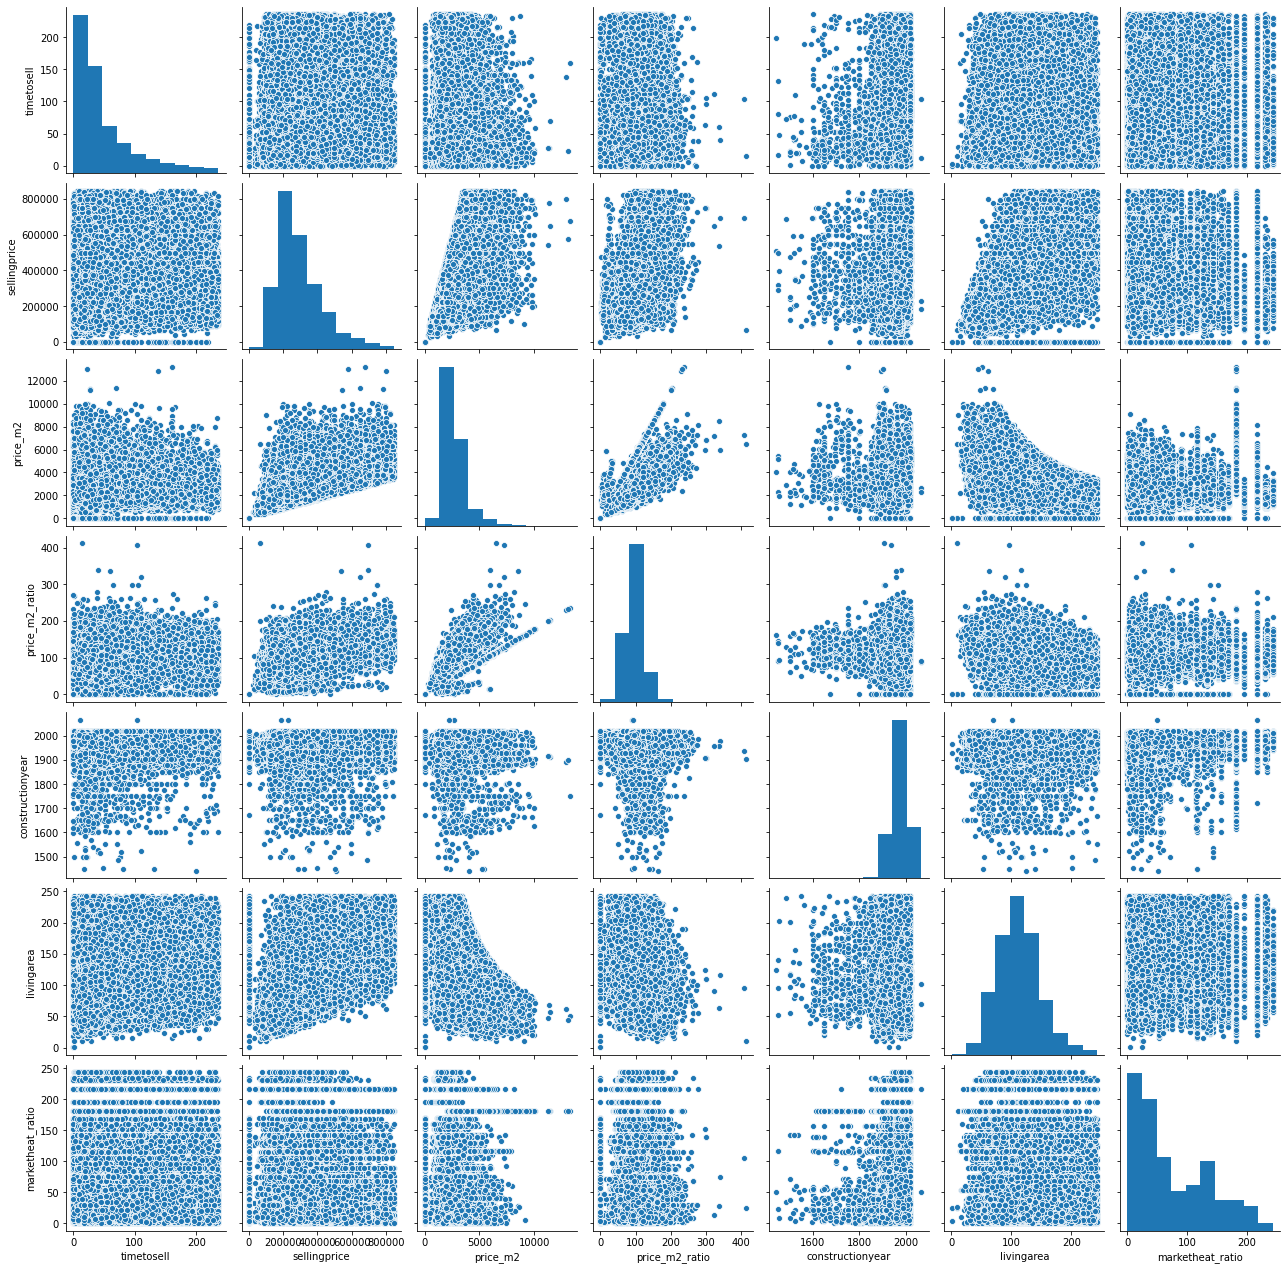

In [23]:
%matplotlib inline
sns.pairplot(sub1_outliers)
# plt.show(sns)

We see that the data after removing outliers with a zscore of 2.576, is somewhat normally distributed. Yet, timetosell and sellingprice are left skewed. There are of course more properties that sell within a few days than houses that need a year to be sold. 


However, as most variables are not normally distributed, we need to apply Logarithmic Transformation.

### Logarithmic Transformation to normalize data

First, we test the linear regression with the skewed data:

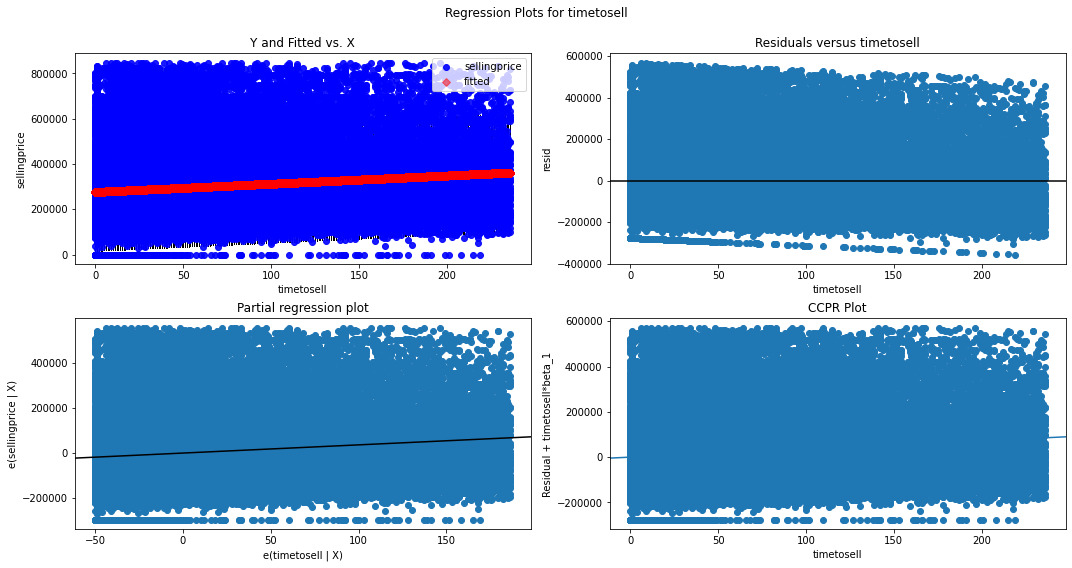

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

f = 'sellingprice~timetosell'
model = ols(formula=f, data=sub1_outliers).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'timetosell', fig=fig)

Now we apply logarithmic transformation on timetosell and livingarea:

Text(0.5, 0, 'log(sellingprice)')

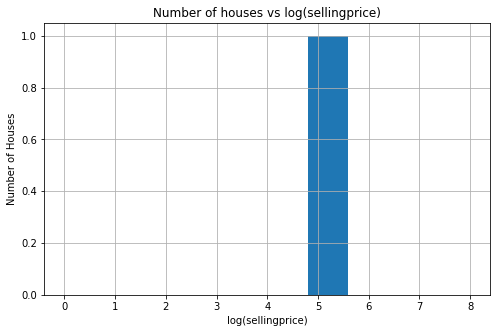

In [25]:
sub1clean = sub1_outliers
sub1clean = sub1clean.replace([np.inf, -np.inf], np.nan)
sub1clean = sub1clean.dropna()
sub1clean['log_sellingprice'] = np.log(sub1clean['sellingprice'])
sub1clean.hist('log_sellingprice',figsize=(8,5), range=(0.0, 8.0))
plt.title('Number of houses vs log(sellingprice)')
plt.ylabel('Number of Houses')
plt.xlabel("log(sellingprice)")

Text(0.5, 0, 'log(timetosell)')

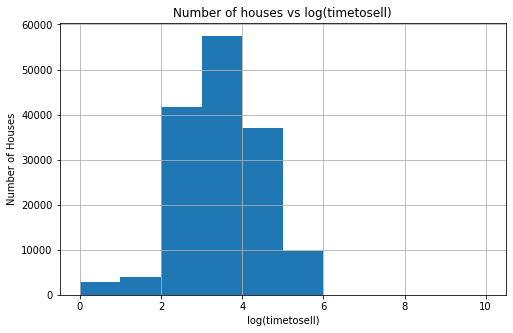

In [32]:
sub1clean['timetosell'] = sub1clean['timetosell'].replace([np.inf, -np.inf], np.nan).dropna(how="all")
sub1clean['log_timetosell'] = np.log(sub1clean['timetosell'])
sub1clean.hist('log_timetosell',figsize=(8,5), range=(0.0, 10.0))
plt.title('Number of houses vs log(timetosell)')
plt.ylabel('Number of Houses')
plt.xlabel("log(timetosell)")

In [34]:
f = 'log_sellingprice~log_timetosell'
model = ols(formula=f, data=sub1clean).fit()

fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(model, 'log_timetosell', fig=fig)

MissingDataError: ignored

In [0]:
print(model.summary())

In [0]:
# plot bivariate scatterplots
fig = plt.figure(figsize=(17,5))

fig.add_subplot(121)
sns.regplot(x="livingarea", y="timetosell", fit_reg=True, data=sub1_outliers);
plt.xlabel("livingarea");
plt.ylabel("timetosell");
plt.title("Scatterplot for the Relationship between livingarea and timetosell");

fig.add_subplot(122)
sns.regplot(x="sellingprice", y="timetosell", fit_reg=True, data=sub1_outliers);
plt.xlabel("sellingprice");
plt.ylabel("timetosell");
plt.title("Scatterplot for the Relationship between sellingprice and timetosell");

fig.tight_layout()
plt.show()

In [0]:
plotDF = df3[['timetosell', 'constructionyear', 'livingarea', 'central_location', 'sellingprice']]
plotDF

### PearsonR Correlation Matrix with pvalues

PearsonR is suitable for all normally distributed numerical variables. Further assumptions must be ensured: linearity and homoscedascicity!

In [0]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sub1 = df1[['timetosell', 'sellingprice', 'price_m2', 'perc_price_of_avg', 'constructionyear', 'livingarea']]

corr1 = sub1
corr2 = sub1

coeffmat = np.zeros((corr1.shape[1], corr2.shape[1]))
pvalmat = np.zeros((corr1.shape[1], corr2.shape[1]))

for i in range(corr1.shape[1]):    
    for j in range(corr2.shape[1]):        
        corrtest = pearsonr(corr1[corr1.columns[i]], corr2[corr2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=corr2.columns, index=corr1.columns)
print( '\033[1m' + 'Correlation Matrix with PearsonR Coefficients \n' + '\033[0m')
print(dfcoeff)

In [0]:
dfpvals = pd.DataFrame(pvalmat, columns=corr2.columns, index=corr1.columns)
print( '\033[1m' + 'Corresponding P-Values that show significance \n' + '\033[0m')
print(dfpvals)

### Correlation Matrix with pvalues for all variables

In [0]:
from scipy.stats import pearsonr, spearmanr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

corr1 = df3
corr2 = df3[['timetosell', 'sellingprice', 'price_m2', 'perc_price_of_avg', 'constructionyear', 'livingarea']]

coeffmat = np.zeros((corr1.shape[1], corr2.shape[1]))
pvalmat = np.zeros((corr1.shape[1], corr2.shape[1]))

for i in range(corr1.shape[1]):    
    for j in range(corr2.shape[1]):        
        corrtest = spearmanr(corr1[corr1.columns[i]], corr2[corr2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

dfcoeff = pd.DataFrame(coeffmat, columns=corr2.columns, index=corr1.columns)
print( '\033[1m' + 'Correlation Matrix with PearsonR Coefficients \n' + '\033[0m')
print(dfcoeff)

In [0]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcoeff, 14))

In [0]:
stats.pearsonr(df3['timetosell'], df3['livingarea'])

In [0]:
stats.spearmanr(df3['sellingprice'], df3['constructionyear'])

In [0]:
stats.pearsonr(df3['sellingprice'], df3['livingarea'])

In [0]:
stats.pearsonr(df3['price_m2'], df3['sellingprice'])

In [0]:
stats.spearmanr(df3['price_m2'], df3['sellingprice'])

In [0]:
stats.spearmanr(df3['price_class_num'], df3['sellingprice'])

In [0]:
stats.pearsonr(df3['timetosell'], df3['marketheat_ratio'])

In [0]:
stats.spearmanr(df3['timetosell'], df3['marketheat_ratio'])

In [0]:
plotareaDF = df2[['totalarea', 'sellingprice']]
plotareaDF = plotareaDF.dropna()
plotareaDF = plotareaDF.apply(pd.to_numeric, errors='coerce').astype(np.int64)
stats.pearsonr(plotareaDF['sellingprice'], plotareaDF['totalarea'])

RESULTS: 

- We find that timetosell and livingarea have a significant weak positive correlation

- We find that sellingprice and constructionyear have a significant weak positive correlation (only SpearmanR which shows that 

- We find that sellingprice and livingarea have a significant strong positive correlation

- We find that sellingprice and price_m2 have a significant strong positive correlation

### Moderation regression (Sellingprice - Timetosell)

In [0]:
sellingprice_garage_timetosellDF = df1[['livingarea', 'garage_and_parking', 'sellingprice']]
sellingprice_garage_timetosellDF = sellingprice_garage_timetosellDF.apply(pd.to_numeric, errors="coerce")
sellingprice_garage_timetosellDF = sellingprice_garage_timetosellDF.dropna()
sellingprice_garage_timetosellDF["garage_and_parking"] = sellingprice_garage_timetosellDF.garage_and_parking.astype("category")

sellingprice_garage_timetosellDF

In [0]:
moderator_garage = sellingprice_garage_timetosellDF.groupby('garage_and_parking')
print(moderator_garage["garage_and_parking"].value_counts(sort=False))

In [0]:
print("association between sellingprice and livingarea - No Garage")
print(scipy.stats.pearsonr(moderator_garage.get_group(0)["sellingprice"],
                           moderator_garage.get_group(0)["livingarea"]))

print("association between sellingprice and livingarea - Garage")
print(scipy.stats.pearsonr(moderator_garage.get_group(1)["sellingprice"],
                           moderator_garage.get_group(1)["livingarea"]))

print("association between sellingprice and livingarea - all")
print(scipy.stats.pearsonr(sellingprice_garage_timetosellDF["sellingprice"], sellingprice_garage_timetosellDF["livingarea"]))


As we can see from the PearsonR outcome of above, having a garage slightly increases the positive strength of the relationship of sellingprice and timetosell. (->significant!)

The moderating influence of having no garage is not significant. 

**Conclusion:**

1. Having a garage/parkingspace has a significant effect on the strength of the relationship between sellingprice and timetosell 

2. In general, sellingprice only has a weak significant relationship with timetosell (r2=0.1557, p=0.00) so that there must also be other factors that play a role in the time needed to sell a house. The variable garage/parking is an interesting moderator as it significantly increases the strength of sellingprice - timetosell from r2=0.1557 to r2=0.1663. 

### Moderation regression (Price class - Timetosell)

## ANOVA (Analysis of Variances in means)

In [0]:
# !pip install researchpy
import pandas as pd
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [0]:
dfgh = df1
dfgh = dfgh[['timetosell', 'pricerange']]
dfgh = dfgh.dropna()
dfgh

In [0]:
rp.summary_cont(dfgh['timetosell'].groupby(dfgh['pricerange']))


In [0]:
results = ols('timetosell ~ pricerange', data=dfgh).fit()
results.summary()


In [0]:
aov_table = sm.stats.anova_lm(results, typ=2)
aov_table

In [0]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['R2'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'R2', 'omega_sq']
    aov = aov[cols]
    return aov

anova_table(aov_table)

Let’s break down this ANOVA table. 
- The pricerange row is the between groups effect which is the overall effect of price on timetosell. 
- The sum of squares for the model (SSM; value 2.49 in the table) is how much variance is explained by our model. 
- The current model explains a significant amount of variance, F(4,172532)= 1360.64, p < 0.00. 
- The residual row is the unsystematic variation in the data (SSR; also called the unexplained variance; value 7.88 in the table). 

In this case, the unsystematic variation represents the natural individual differences in libido and natural different reactions to the drug, Difficile.

In this case, the unexplained variance represents the individual real estate differences in price in relation to time to sell that can be caused by many factors like the informal factor noise.

In [0]:
results.diagn

In [0]:
stats.levene(dfgh['timetosell'][dfgh['pricerange'] == '0.2'],
             dfgh['timetosell'][dfgh['pricerange'] == '0.4'],
             dfgh['timetosell'][dfgh['pricerange'] == '0.6'], 
             dfgh['timetosell'][dfgh['pricerange'] == '0.8'], 
             dfgh['timetosell'][dfgh['pricerange'] == '1.0'])

In [0]:
stats.shapiro(results.resid)

In [0]:
stats.ttest_ind(dfgh['timetosell'][dfgh['pricerange'] == '1.0'], dfgh['timetosell'][dfgh['pricerange'] == '0.6'])

## Visualing descriptives (frequencies, common aspects etc)

In [0]:
%matplotlib inline
pd.crosstab(DummyDF.pricerange,DummyDF.gardenindication).plot(kind='bar')
plt.title('Frequency of garden per price class')
plt.xlabel('pricerange')
plt.ylabel('Garden')

In [0]:
%matplotlib inline
pd.crosstab(DummyDF.timetosell_range,DummyDF['noisy_property']).plot(kind='bar')
plt.title('Frequency of noisy houses')
plt.xlabel('Time to sell')
plt.ylabel('Real estate listings')

In [0]:
%matplotlib inline
pd.crosstab(DummyDF.timetosell_range,DummyDF['quiet_property']).plot(kind='bar')
plt.title('Frequency of quiet houses')
plt.xlabel('Time to sell')
plt.ylabel('Real estate listings')

In [0]:
%matplotlib inline
pd.crosstab(DummyDF.timetosell_range,DummyDF['garage_and_parking']).plot(kind='bar')
plt.title('Frequency of properties with garage or parkingspace')
plt.xlabel('Time to sell')
plt.ylabel('Real estate listings')

In [0]:
%matplotlib inline
pd.crosstab(DummyDF.timetosell_range,DummyDF['light_flooded']).plot(kind='bar')
plt.title('Frequency of light-flooded listings')
plt.xlabel('Time to sell')
plt.ylabel('Real estate listings')

There seems to be a slight correlation of a bright, light-flooded property and faster time to sell. Let's test this: 

## Pearson Testing

In [0]:
# DummyDF['timetosell_range_num'] = DummyDF['timetosell_range'].replace(to_replace=['very slow', 'slow', 'medium', 'fast', 'very fast'], value=[1, 2, 3, 4, 5])
# DummyDF['light_flooded'] = DummyDF['light_flooded'].astype('str')
# DummyDF['light_flooded_num'] = DummyDF['light_flooded'].replace(to_replace=['True', 'False'], value=[1, 0])
# DummyDF

In [0]:
# DummyDF['timetosell_range_num'] = DummyDF['timetosell_range_num'].apply(pd.to_numeric, downcast='integer', errors='coerce')
# DummyDF['light_flooded_num'] = DummyDF['light_flooded_num'].apply(pd.to_numeric, downcast='integer', errors='coerce')

In [0]:
DummyDF2 = df
DummyDF2 = DummyDF2.apply(pd.to_numeric, downcast='integer', errors='coerce')

In [0]:
DummyDF2 = pd.to_numeric(DummyDF2, errors='coerce').fillna(0).astype(np.int64)


In [0]:
DummyDF2

In [0]:
stats.pearsonr(DummyDF['timetosell'], DummyDF['garage_and_parking'])

In [0]:
stats.pearsonr(DummyDF2['avg_price_m2_per_city'], DummyDF2['Population density'])

In [0]:
stats.pearsonr(DummyDF2['avg_price_m2_per_city'], DummyDF2['Total theft from home and barn'])

In [0]:
stats.pearsonr(DummyDF2['avg_price_m2_per_city'], DummyDF2['Households without kids'])

In [0]:
stats.pearsonr(DummyDF2['avg_price_m2_per_city'], DummyDF2['Households with kids'])

In [0]:
DummyDF2.Average_income = pd.to_numeric(DummyDF2.Average_income, errors='coerce').fillna(0).astype(np.int64)

stats.pearsonr(DummyDF2['avg_price_m2_per_city'], DummyDF2['Average_income'])

In [0]:
stats.spearmanr(DummyDF2['avg_price_m2_per_city'], DummyDF2['Average_income'])

In [0]:
stats.pearsonr(DummyDF2['timetosell'], DummyDF2['garage_and_parking'])

## Testing Assumptions for Regression

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [0]:
linear_X, linear_y = datasets.make_regression(n_samples=boston.data.shape[0],
                                              n_features=boston.data.shape[1],
                                              noise=75, random_state=46)

# Setting feature names to x1, x2, x3, etc. if they are not defined
linear_feature_names = ['X'+str(feature+1) for feature in range(linear_X.shape[1])]